# Reading overlapping tiles with `georeader`

This tutorial shows how to read overlapping parts of two raster objects of different spatial resolution and with different transforms.

For this tutorial we will use a GeoTIFF file derived from an AVIRIS-NG image that we downloaded from [here](https://zenodo.org/record/5610307#.Yp83JhxBzRZ) and a Sentinel-2 file SAFE file that can be read directly from the public GCP bucket (or downloaded from [Copernicus SciHub](https://scihub.copernicus.eu/dhus)).

## Install package with Google dependecies 

This is needed to read image from S2 bucket

```
pip install georeader-spaceml fsspec gcsfs
```

Step 1: Create the reader object for the AVIRIS image

In [1]:
%%time

from georeader.rasterio_reader import RasterioReader

aviris_reader = RasterioReader("/home/gonzalo/Downloads/permian_2019/permian_2019/ang20190928t185111-4_r6871_c424_rgb.tif")
aviris_reader

CPU times: user 519 ms, sys: 1.84 s, total: 2.36 s
Wall time: 163 ms


 
         Paths: ['/home/gonzalo/Downloads/permian_2019/permian_2019/ang20190928t185111-4_r6871_c424_rgb.tif']
         Transform: | 5.99, 4.35, 592577.80|
| 4.35,-5.99, 3519916.50|
| 0.00, 0.00, 1.00|
         Shape: (3, 151, 151)
         Resolution: (7.400000000000001, 7.400000000000001)
         Bounds: (592577.7996484624, 3519012.5018222863, 594138.5864788886, 3520573.2886527125)
         CRS: EPSG:32613
         nodata: None
         fill_value_default: 0
        

In [2]:
%%time

aviris_reader_in_memory = aviris_reader.load()
aviris_reader_in_memory.values

CPU times: user 0 ns, sys: 2.35 ms, total: 2.35 ms
Wall time: 2.35 ms


array([[[253, 254, 237, ..., 187, 181, 134],
        [231, 221, 199, ..., 203, 197, 164],
        [193, 194, 194, ..., 212, 202, 193],
        ...,
        [ 90,  88,  88, ..., 183, 160, 170],
        [ 92,  95,  95, ..., 192, 172, 181],
        [ 88,  93,  89, ..., 194, 187, 210]],

       [[235, 230, 213, ..., 172, 165, 131],
        [216, 203, 181, ..., 185, 180, 153],
        [184, 178, 177, ..., 189, 182, 178],
        ...,
        [ 96,  96,  96, ..., 183, 162, 171],
        [ 99, 100, 100, ..., 191, 173, 181],
        [ 97,  98,  96, ..., 193, 185, 205]],

       [[190, 183, 163, ..., 148, 141, 116],
        [174, 165, 142, ..., 151, 152, 129],
        [151, 145, 143, ..., 148, 147, 148],
        ...,
        [102, 101, 100, ..., 166, 149, 155],
        [103, 104, 103, ..., 173, 158, 163],
        [102, 102, 100, ..., 175, 167, 180]]], dtype=uint8)

Step 2: Create the reader object for the Sentinel-2 image

In [3]:
%%time

import os
from georeader.readers import S2_SAFE_reader
# This is required to do advaced operations in the GCP bucket
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "path/to/file.json"
# os.environ["GS_USER_PROJECT"] = "project-name"
# S2_SAFE_reader.DEFAULT_REQUESTER_PAYS=True

os.environ["GS_NO_SIGN_REQUEST"] = "YES"

# Read only RGB bands

s2path = "gs://gcp-public-data-sentinel-2/tiles/13/S/ER/S2B_MSIL1C_20190928T173109_N0208_R055_T13SER_20190928T205958.SAFE"
s2_reader = S2_SAFE_reader.s2loader(s2path, out_res=10, bands=["B04", "B03", "B02"])
s2_reader

CPU times: user 229 ms, sys: 27.4 ms, total: 257 ms
Wall time: 344 ms


 
         gs://gcp-public-data-sentinel-2/tiles/13/S/ER/S2B_MSIL1C_20190928T173109_N0208_R055_T13SER_20190928T205958.SAFE
         Transform: | 10.00, 0.00, 499980.00|
| 0.00,-10.00, 3600000.00|
| 0.00, 0.00, 1.00|
         Shape: (3, 10980, 10980)
         Resolution: (10.0, 10.0)
         Bounds: (499980.0, 3490200.0, 609780.0, 3600000.0)
         CRS: EPSG:32613
         bands: ['B04', 'B03', 'B02']
         fill_value_default: 0
        

## Read the S2 image at the AVIRIS location using `read_from_bounds`

In [4]:
%%time

from georeader import read

s2_at_aviris_loc = read.read_from_bounds(s2_reader, aviris_reader_in_memory.bounds, crs_bounds=aviris_reader_in_memory.crs)
s2_at_aviris_loc

CPU times: user 4.13 ms, sys: 180 µs, total: 4.31 ms
Wall time: 3.28 ms


 
         gs://gcp-public-data-sentinel-2/tiles/13/S/ER/S2B_MSIL1C_20190928T173109_N0208_R055_T13SER_20190928T205958.SAFE
         Transform: | 10.00, 0.00, 592570.00|
| 0.00,-10.00, 3520580.00|
| 0.00, 0.00, 1.00|
         Shape: (3, 157, 157)
         Resolution: (10.0, 10.0)
         Bounds: (592570.0, 3519010.0, 594140.0, 3520580.0)
         CRS: EPSG:32613
         bands: ['B04', 'B03', 'B02']
         fill_value_default: 0
        

In [5]:
%%time
s2_at_aviris_loc_in_memory = s2_at_aviris_loc.load()
s2_at_aviris_loc_in_memory.values

CPU times: user 772 ms, sys: 203 ms, total: 976 ms
Wall time: 24.5 s


array([[[2387, 2649, 2654, ..., 2302, 2292, 2241],
        [2244, 2454, 2630, ..., 2412, 2376, 2339],
        [2540, 2432, 2373, ..., 2473, 2442, 2403],
        ...,
        [1347, 1312, 1325, ..., 1851, 2073, 2010],
        [1268, 1265, 1368, ..., 2194, 2193, 2098],
        [1261, 1293, 1392, ..., 2235, 2018, 1881]],

       [[1803, 1946, 1970, ..., 1802, 1801, 1754],
        [1739, 1879, 1971, ..., 1873, 1876, 1810],
        [1914, 1862, 1796, ..., 1920, 1888, 1867],
        ...,
        [1265, 1239, 1268, ..., 1611, 1750, 1705],
        [1194, 1210, 1283, ..., 1815, 1851, 1770],
        [1181, 1214, 1271, ..., 1886, 1671, 1626]],

       [[1622, 1689, 1683, ..., 1621, 1653, 1576],
        [1517, 1632, 1690, ..., 1677, 1696, 1624],
        [1665, 1637, 1614, ..., 1718, 1703, 1637],
        ...,
        [1294, 1302, 1299, ..., 1459, 1566, 1569],
        [1288, 1256, 1333, ..., 1617, 1599, 1591],
        [1273, 1266, 1350, ..., 1662, 1561, 1474]]], dtype=uint16)

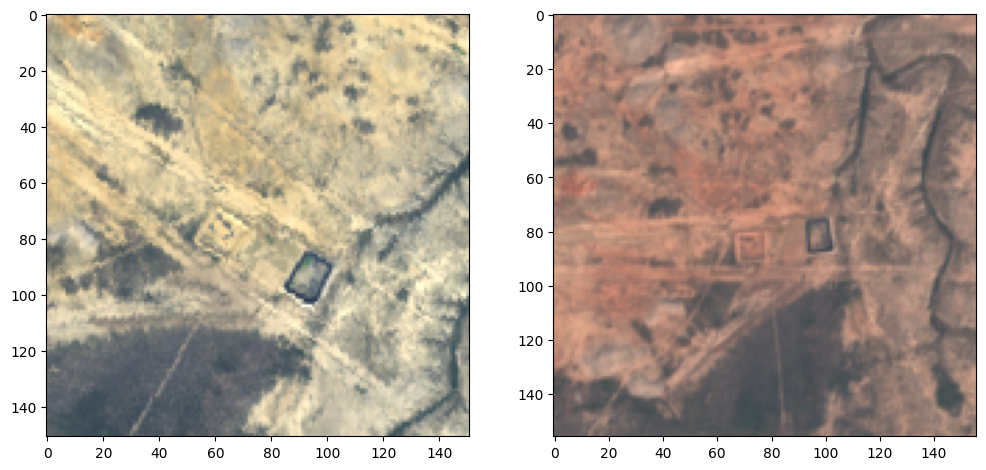

In [17]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(aviris_reader_in_memory.values.transpose((1,2,0)))
ax[1].imshow(np.clip(s2_at_aviris_loc_in_memory.values/3_500,0,1).transpose((1,2,0)))

## Convert to and from `xarray.DataArray`

In [8]:
from georeader import dataarray
dr = dataarray.toDataArray(s2_at_aviris_loc_in_memory)
dr

<xarray.DataArray (band: 3, y: 157, x: 157)> Size: 148kB
array([[[2387, 2649, 2654, ..., 2302, 2292, 2241],
        [2244, 2454, 2630, ..., 2412, 2376, 2339],
        [2540, 2432, 2373, ..., 2473, 2442, 2403],
        ...,
        [1347, 1312, 1325, ..., 1851, 2073, 2010],
        [1268, 1265, 1368, ..., 2194, 2193, 2098],
        [1261, 1293, 1392, ..., 2235, 2018, 1881]],

       [[1803, 1946, 1970, ..., 1802, 1801, 1754],
        [1739, 1879, 1971, ..., 1873, 1876, 1810],
        [1914, 1862, 1796, ..., 1920, 1888, 1867],
        ...,
        [1265, 1239, 1268, ..., 1611, 1750, 1705],
        [1194, 1210, 1283, ..., 1815, 1851, 1770],
        [1181, 1214, 1271, ..., 1886, 1671, 1626]],

       [[1622, 1689, 1683, ..., 1621, 1653, 1576],
        [1517, 1632, 1690, ..., 1677, 1696, 1624],
        [1665, 1637, 1614, ..., 1718, 1703, 1637],
        ...,
        [1294, 1302, 1299, ..., 1459, 1566, 1569],
        [1288, 1256, 1333, ..., 1617, 1599, 1591],
        [1273, 1266, 1350, ..., 1662, 1561, 1474]]], dtype=uint16)
Coordinates:
  * x        (x) float64 1kB 5.926e+05 5.926e+05 ... 5.941e+05 5.941e+05
  * y        (y) float64 1kB 3.521e+06 3.521e+06 ... 3.519e+06 3.519e+06
Dimensions without coordinates: band
Attributes:
    crs:      EPSG:32613

In [10]:
geotensorback = dataarray.fromDataArray(dr)
geotensorback

 
         Transform: | 10.00, 0.00, 592570.00|
| 0.00,-10.00, 3520580.00|
| 0.00, 0.00, 1.00|
         Shape: (3, 157, 157)
         Resolution: (10.0, 10.0)
         Bounds: (592570.0, 3519010.0, 594140.0, 3520580.0)
         CRS: EPSG:32613
         fill_value_default: 0
        

## Read the S2 image at the AVIRIS location using `read_from_center_coords`

In [18]:
center_coords_aviris = aviris_reader_in_memory.transform * (aviris_reader_in_memory.shape[1] / 2, aviris_reader_in_memory.shape[0] / 2)
center_coords_aviris

(593036.3218595202, 3520235.9129436193)

In [19]:
%%time


s2_at_aviris_loc = read.read_from_center_coords(s2_reader, shape=(150,150),
                                                center_coords=center_coords_aviris, crs_center_coords=aviris_reader_in_memory.crs)
s2_at_aviris_loc

CPU times: user 5.6 ms, sys: 560 µs, total: 6.16 ms
Wall time: 4.71 ms


 
         gs://gcp-public-data-sentinel-2/tiles/13/S/ER/S2B_MSIL1C_20190928T173109_N0208_R055_T13SER_20190928T205958.SAFE
         Transform: | 10.00, 0.00, 592290.00|
| 0.00,-10.00, 3520990.00|
| 0.00, 0.00, 1.00|
         Shape: (3, 150, 150)
         Resolution: (10.0, 10.0)
         Bounds: (592290.0, 3519490.0, 593790.0, 3520990.0)
         CRS: EPSG:32613
         bands: ['B04', 'B03', 'B02']
         fill_value_default: 0
        

In [20]:
%%time
s2_at_aviris_loc_in_memory = s2_at_aviris_loc.load()
s2_at_aviris_loc_in_memory.values

CPU times: user 857 ms, sys: 9.61 ms, total: 867 ms
Wall time: 117 ms


array([[[2403, 2577, 2603, ..., 1957, 2000, 1975],
        [2360, 2327, 2266, ..., 2012, 1952, 1887],
        [2298, 2156, 2188, ..., 2026, 2011, 1925],
        ...,
        [2368, 2257, 2093, ..., 2197, 2050, 2044],
        [2316, 2276, 2117, ..., 2418, 2195, 1936],
        [2370, 2346, 2337, ..., 2401, 2182, 1805]],

       [[1962, 2124, 2189, ..., 1695, 1664, 1711],
        [1895, 1891, 1861, ..., 1690, 1675, 1602],
        [1864, 1769, 1811, ..., 1715, 1789, 1610],
        ...,
        [1842, 1765, 1661, ..., 1756, 1714, 1698],
        [1817, 1764, 1653, ..., 1955, 1785, 1633],
        [1880, 1804, 1762, ..., 1932, 1752, 1546]],

       [[1777, 1899, 1964, ..., 1584, 1567, 1603],
        [1688, 1676, 1719, ..., 1580, 1540, 1509],
        [1640, 1561, 1644, ..., 1649, 1626, 1526],
        ...,
        [1589, 1559, 1443, ..., 1647, 1579, 1553],
        [1613, 1565, 1441, ..., 1705, 1601, 1534],
        [1627, 1575, 1521, ..., 1764, 1610, 1461]]], dtype=uint16)

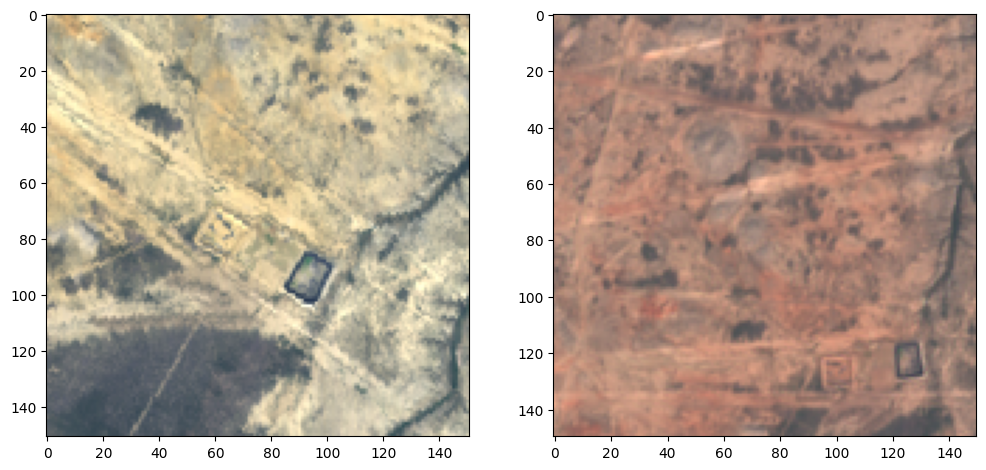

In [21]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(aviris_reader_in_memory.values.transpose((1,2,0)))
ax[1].imshow(np.clip(s2_at_aviris_loc_in_memory.values/3_500,0,1).transpose((1,2,0)))

## Read the S2 image at the AVIRIS location using `read_reproject_like`

This will read the S2 image with the same resolution and transform as the AVIRIS image.

In [22]:
%%time

s2_at_aviris_loc = read.read_reproject_like(s2_reader, aviris_reader_in_memory)
s2_at_aviris_loc

CPU times: user 773 ms, sys: 5.81 ms, total: 779 ms
Wall time: 127 ms


 
         Transform: | 5.99, 4.35, 592577.80|
| 4.35,-5.99, 3519916.50|
| 0.00, 0.00, 1.00|
         Shape: (3, 151, 151)
         Resolution: (7.400000000038687, 7.399999999944504)
         Bounds: (592577.7996484624, 3519012.5018222863, 594138.5864788886, 3520573.2886527125)
         CRS: EPSG:32613
         fill_value_default: 0
        

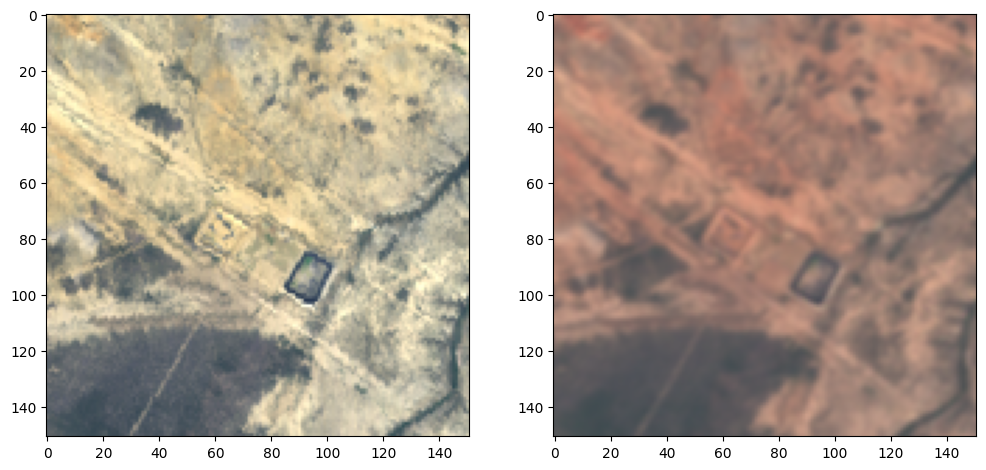

In [23]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(aviris_reader_in_memory.values.transpose((1,2,0)))
ax[1].imshow(np.clip(s2_at_aviris_loc.values/3_500,0,1).transpose((1,2,0)))

## Read the S2 image at the AVIRIS location using `read_reproject`

With this we will show how to reproject the S2 image to the AVIRIS grid but keeping the original spatial resolution of Sentinel-2 (10m).

In [24]:
%%time
import rasterio.windows
from math import ceil

shape_out = ceil(aviris_reader_in_memory.shape[1] * aviris_reader_in_memory.res[0] / s2_reader.res[0]), ceil(aviris_reader_in_memory.shape[2] * aviris_reader_in_memory.res[1] / s2_reader.res[1])

s2_at_aviris_loc = read.read_reproject(s2_reader, dst_crs=aviris_reader_in_memory.crs, 
                                       dst_transform=aviris_reader_in_memory.transform,
                                       resolution_dst_crs=s2_reader.res,
                                       window_out=rasterio.windows.Window(0,0, width=shape_out[-1], height=shape_out[-2]))
s2_at_aviris_loc

CPU times: user 766 ms, sys: 15.9 ms, total: 782 ms
Wall time: 111 ms


 
         Transform: | 8.09, 5.88, 592577.80|
| 5.88,-8.09, 3519916.50|
| 0.00, 0.00, 1.00|
         Shape: (3, 112, 112)
         Resolution: (9.999999999910532, 10.000000000141569)
         Bounds: (592577.7996484624, 3519010.398378094, 594142.2181647301, 3520574.816894365)
         CRS: EPSG:32613
         fill_value_default: 0
        

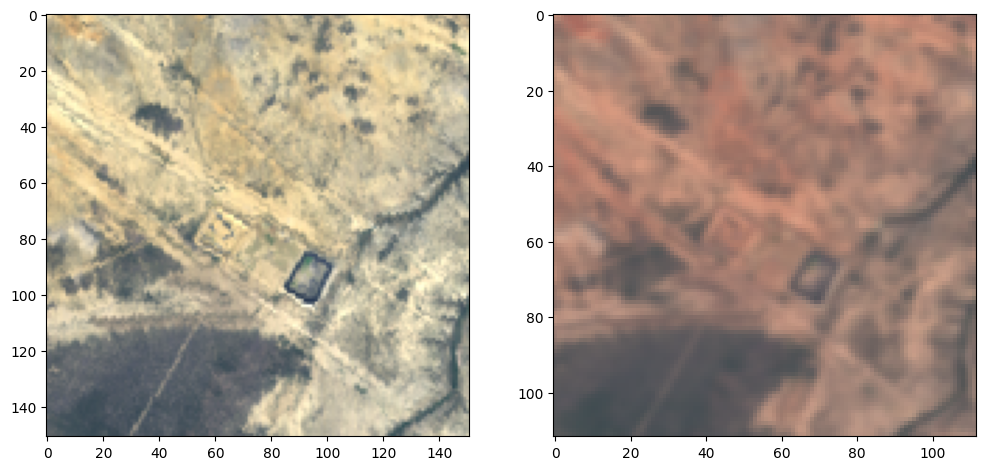

In [25]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(aviris_reader_in_memory.values.transpose((1,2,0)))
ax[1].imshow(np.clip(s2_at_aviris_loc.values/3_500,0,1).transpose((1,2,0)))

## Downscale AVIRIS-NG to the Sentinel-2 resolution (10m)

This AVIRIS-NG image is at 7.40m resolution and we'd like to convert it to 10m resolution. We will set the option anti_aliasing to True to avoid aliasing efects of reducing the sampling size.

In [26]:
avirs_at_10m = read.resize(aviris_reader_in_memory,resolution_dst=s2_reader.res,anti_aliasing=True)
avirs_at_10m

 
         Transform: | 8.09, 5.88, 592577.80|
| 5.88,-8.09, 3519916.50|
| 0.00, 0.00, 1.00|
         Shape: (3, 112, 112)
         Resolution: (9.999999999910532, 10.000000000141569)
         Bounds: (592577.7996484624, 3519010.398378094, 594142.2181647301, 3520574.816894365)
         CRS: EPSG:32613
         fill_value_default: 0
        

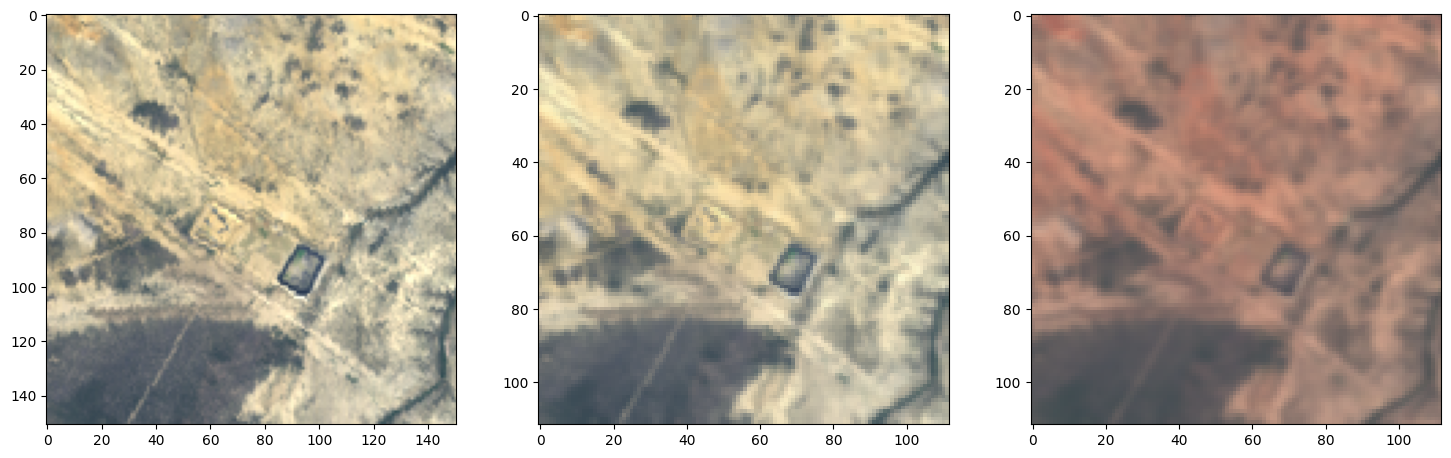

In [27]:
fig, ax = plt.subplots(1,3,figsize=(18,6))
ax[0].imshow(aviris_reader_in_memory.values.transpose((1,2,0)))
ax[1].imshow(avirs_at_10m.values.transpose((1,2,0)))
ax[2].imshow(np.clip(s2_at_aviris_loc.values/3_500,0,1).transpose((1,2,0)))

## Licence
The georeader package is published under a [GNU Lesser GPL v3 licence](https://www.gnu.org/licenses/lgpl-3.0.en.html)

 If you find this work useful please cite:

```
@article{ruzicka_starcop_2023,
	title = {Semantic segmentation of methane plumes with hyperspectral machine learning models},
	volume = {13},
	issn = {2045-2322},
	url = {https://www.nature.com/articles/s41598-023-44918-6},
	doi = {10.1038/s41598-023-44918-6},
	number = {1},
	journal = {Scientific Reports},
	author = {Růžička, Vít and Mateo-Garcia, Gonzalo and Gómez-Chova, Luis and Vaughan, Anna, and Guanter, Luis and Markham, Andrew},
	month = nov,
	year = {2023},
	pages = {19999},
}
```